# Unsupervised

### Preprocess the dataset for clustering

In [100]:
import pandas as pd

df = pd.read_csv('temp/olist_orders_dataset_df.csv')


Create a balanced dataset.

In [101]:
from sklearn.utils import resample, shuffle

df_True = df[df.anomaly]
df_False = df[df.anomaly==False]

df_False = resample(df_False, replace=True, n_samples=df_True.shape[0])

df_balanced = shuffle(pd.concat([df_True, df_False]))
df_balanced.reset_index(drop=True, inplace=True)
X_balanced = df_balanced.drop(['anomaly'], axis=1)
y_balanced = df_balanced['anomaly']

Using only selected features

In [102]:
X = df.drop(['anomaly'], axis=1)
y = df['anomaly']

columns1 = ['time_estimate_delivery', 'year', 'month', 'day', 'freight_value', 'seller_zip_code_prefix', 'seller_geolocation_lat', 'seller_geolocation_lng','customer_zip_code_prefix', 'customer_geolocation_lat', 'customer_geolocation_lng', 'distance']

In [103]:
X_balanced = pd.DataFrame(X_balanced[columns1])
X = pd.DataFrame(X[columns1])

Transform the features to follow a normal distribution

In [104]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X_balanced = pd.DataFrame(qt.fit_transform(X_balanced), columns=columns1)
X = pd.DataFrame(qt.fit_transform(X), columns=columns1)

### Create a Table of performance

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

table_of_performance = pd.DataFrame(columns=['algorithm', 'confusion matrix', 'accuracy', 'precision', 'recall', 'rand index', 'mutual information based score', 'homogeneity', 'completeness', 'v-measure'])

def add_performance(algorithm, y, y_predict):
    global table_of_performance

    cm = confusion_matrix(y, y_predict)
    accuracy = accuracy_score(y, y_predict)
    precision = precision_score(y, y_predict)
    recall = recall_score(y, y_predict)
    rand_index = rand_score(y, y_predict)
    mutual_info_score = adjusted_mutual_info_score(y, y_predict)
    homogeneity = homogeneity_score(y, y_predict)
    completeness = completeness_score(y, y_predict)
    v_measure = v_measure_score(y, y_predict)

    new_row = {'algorithm': algorithm, 'confusion matrix': cm, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'rand index': rand_index, 'mutual information based score': mutual_info_score, 'homogeneity': homogeneity, 'completeness': completeness, 'v-measure': v_measure}

    table_of_performance.loc[len(table_of_performance)] = new_row

### Visualization of clustering after PCA

unbalanced

<Axes: xlabel='x', ylabel='y'>

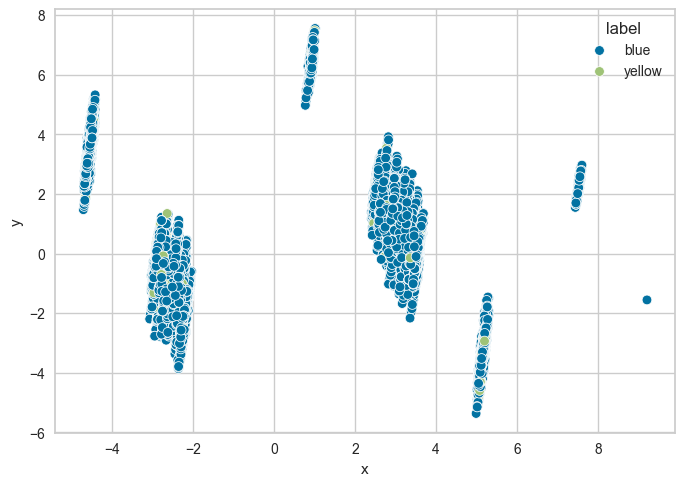

In [106]:
from sklearn.decomposition import  PCA

pca = PCA(n_components=2)
pct = pca.fit_transform(X)

colors = ['yellow' if elem else 'blue' for elem in y]

data = pd.concat([pd.DataFrame(pct), pd.DataFrame(colors)], axis=1)

data.columns = ['x', 'y', 'label']

import seaborn as sns

sns.scatterplot(data=data, x="x", y="y", hue="label")

balanced

<Axes: xlabel='x', ylabel='y'>

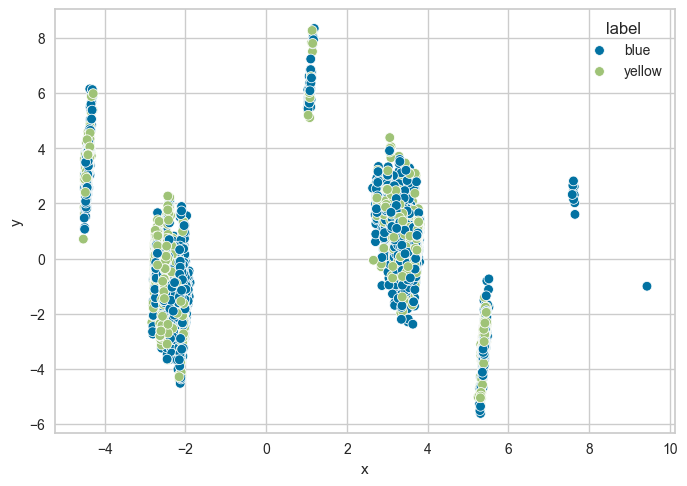

In [107]:
from sklearn.decomposition import  PCA

pca_balanced = PCA(n_components=2)
pct_balanced = pca_balanced.fit_transform(X_balanced)

colors_balanced = ['yellow' if elem else 'blue' for elem in y_balanced]

data_balanced = pd.concat([pd.DataFrame(pct_balanced), pd.DataFrame(colors_balanced)], axis=1)

data_balanced.columns = ['x', 'y', 'label']

sns.scatterplot(data=data_balanced, x="x", y="y", hue="label")

In [108]:
X_balanced.shape

(11008, 12)

In [109]:
y_balanced.value_counts()

anomaly
False    5504
True     5504
Name: count, dtype: int64

### KMeans

#### Unbalanced KMeans

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

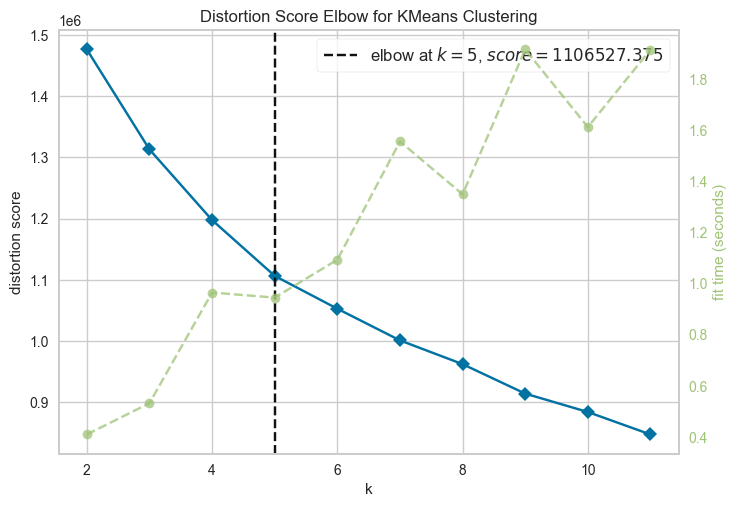

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The optimal number of clusters is 5.

In [111]:
k_means = KMeans(init="k-means++", n_clusters=2, n_init=10, random_state=0)
k_means.fit(X)

from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

from sklearn.metrics.pairwise import pairwise_distances_argmin_min

k_means_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, k_means_cluster_centers)).T
k_means_distances_df.columns = ['cluster', 'distance']

k_means_distances_df = pd.concat([k_means_distances_df, y], axis=1)
print(k_means_distances_df.groupby(['cluster', 'anomaly']).count())
y_predict = k_means_distances_df['cluster'].map({0: False, 1: True})
add_performance('KMeans', y, y_predict)

                 distance
cluster anomaly          
0.0     False       44247
        True         1982
1.0     False       52529
        True         3522


Kmeans doesn't provide any useful information.

#### Balanced KMeans

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

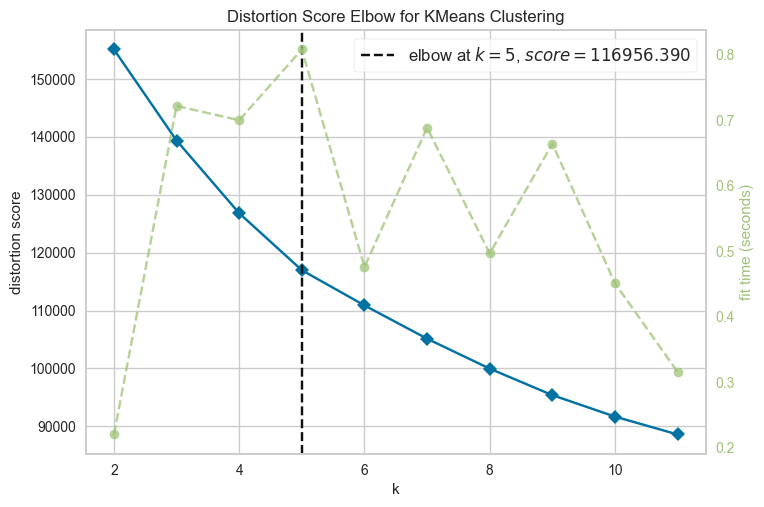

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [112]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model_balanced = KMeans()
visualizer_balanced = KElbowVisualizer(model_balanced, k=(2, 12))

visualizer_balanced.fit(X_balanced)        # Fit the data to the visualizer
visualizer_balanced.show()        # Finalize and render the figure

In [113]:
k_means_balanced = KMeans(init="k-means++", n_clusters=2, n_init=10, random_state=0)
k_means_balanced.fit(X_balanced)

k_means_cluster_centers_balanced = k_means_balanced.cluster_centers_

k_means_labels_balanced = pairwise_distances_argmin(X_balanced, k_means_cluster_centers_balanced)

k_means_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, k_means_cluster_centers_balanced)).T
k_means_distances_df_balanced.columns = ['cluster', 'distance']
k_means_distances_df_balanced = pd.concat([k_means_distances_df_balanced, y_balanced], axis=1)
print(k_means_distances_df_balanced.groupby(['cluster', 'anomaly']).count())
y_predict_balanced = k_means_distances_df_balanced['cluster'].map({0: False, 1: True})
add_performance('KMeans balanced', y_balanced, y_predict_balanced)

                 distance
cluster anomaly          
0.0     False        2923
        True         3522
1.0     False        2581
        True         1982


### Affinity Propagation

#### Unbalanced

Trying the algorithm on unbalanced dataset is computationally impossible and meaningless.

In [114]:
'''
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
len(cluster_centers_indices)
'''

'\nfrom sklearn.cluster import AffinityPropagation\n\naf = AffinityPropagation(random_state=0).fit(X)\ncluster_centers_indices = af.cluster_centers_indices_\nlabels = af.labels_\nlen(cluster_centers_indices)\n'

#### Balanced

In [115]:
'''
from sklearn.cluster import AffinityPropagation

pca = PCA(n_components=5)
pct_balanced = pca.fit_transform(X_balanced)
af_balanced = AffinityPropagation(random_state=0).fit(pct_balanced)
cluster_centers_indices_balanced = af_balanced.cluster_centers_indices_
labels_balanced = af_balanced.labels_
len(cluster_centers_indices_balanced)
'''

'\nfrom sklearn.cluster import AffinityPropagation\n\npca = PCA(n_components=5)\npct_balanced = pca.fit_transform(X_balanced)\naf_balanced = AffinityPropagation(random_state=0).fit(pct_balanced)\ncluster_centers_indices_balanced = af_balanced.cluster_centers_indices_\nlabels_balanced = af_balanced.labels_\nlen(cluster_centers_indices_balanced)\n'

### Mean shift

#### Unbalanced

In [116]:
'''
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
'''

'\nfrom sklearn.cluster import MeanShift, estimate_bandwidth\n\nbandwidth = estimate_bandwidth(X, quantile=0.3)\n\nms = MeanShift(bandwidth=bandwidth, bin_seeding=True)\nms.fit(X)\nlabels = ms.labels_\ncluster_centers = ms.cluster_centers_\n'

In [117]:
'''
mean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T
mean_shift_distances_df.columns = ['cluster', 'distance']
mean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)
print(mean_shift_distances_df.groupby(['cluster', 'ontime']).mean())
print(mean_shift_distances_df.groupby(['cluster', 'ontime']).count())
'''

"\nmean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T\nmean_shift_distances_df.columns = ['cluster', 'distance']\nmean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)\nprint(mean_shift_distances_df.groupby(['cluster', 'ontime']).mean())\nprint(mean_shift_distances_df.groupby(['cluster', 'ontime']).count())\n"

#### Balanced

In [118]:
'''
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth_balanced = estimate_bandwidth(X_balanced, quantile=0.3)

ms_balanced = MeanShift(bandwidth=bandwidth_balanced, bin_seeding=True)
ms_balanced.fit(X_balanced)
labels_balanced = ms_balanced.labels_
cluster_centers_balanced = ms_balanced.cluster_centers_
'''

'\nfrom sklearn.cluster import MeanShift, estimate_bandwidth\n\nbandwidth_balanced = estimate_bandwidth(X_balanced, quantile=0.3)\n\nms_balanced = MeanShift(bandwidth=bandwidth_balanced, bin_seeding=True)\nms_balanced.fit(X_balanced)\nlabels_balanced = ms_balanced.labels_\ncluster_centers_balanced = ms_balanced.cluster_centers_\n'

In [119]:
'''
mean_shift_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, cluster_centers_balanced)).T
mean_shift_distances_df_balanced.columns = ['cluster', 'distance']
mean_shift_distances_df_balanced = pd.concat([mean_shift_distances_df_balanced, y_balanced], axis=1)
print(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).mean())
print(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).count())
'''

"\nmean_shift_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, cluster_centers_balanced)).T\nmean_shift_distances_df_balanced.columns = ['cluster', 'distance']\nmean_shift_distances_df_balanced = pd.concat([mean_shift_distances_df_balanced, y_balanced], axis=1)\nprint(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).mean())\nprint(mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).count())\n"

### Hierarchical clustering

#### Unbalanced

In [120]:
'''
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering = AgglomerativeClustering(n_clusters=2).fit(X)
'''

'\nfrom sklearn.cluster import AgglomerativeClustering\n\nhierarchical_clustering = AgglomerativeClustering(n_clusters=2).fit(X)\n'

In [121]:
'''
hierarchical_clustering_labels_df = pd.DataFrame(hierarchical_clustering.labels_, columns=['cluster'])
hierarchical_clustering_labels_df = pd.concat([hierarchical_clustering_labels_df, y], axis=1)
pd.DataFrame(hierarchical_clustering_labels_df.value_counts())
'''

"\nhierarchical_clustering_labels_df = pd.DataFrame(hierarchical_clustering.labels_, columns=['cluster'])\nhierarchical_clustering_labels_df = pd.concat([hierarchical_clustering_labels_df, y], axis=1)\npd.DataFrame(hierarchical_clustering_labels_df.value_counts())\n"

#### Balanced

In [122]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering_balanced = AgglomerativeClustering(n_clusters=2).fit(X_balanced)

In [123]:
hierarchical_clustering_labels_df_balanced = pd.DataFrame(hierarchical_clustering_balanced.labels_, columns=['cluster'])
hierarchical_clustering_labels_df_balanced = pd.concat([hierarchical_clustering_labels_df_balanced, y_balanced], axis=1)
print(hierarchical_clustering_labels_df_balanced.value_counts())

y_predict_balanced = hierarchical_clustering_labels_df_balanced['cluster'].map({0: True, 1: False})
add_performance('hierarchical clustering balanced', y_balanced, y_predict_balanced)

cluster  anomaly
0        True       3594
         False      3041
1        False      2463
         True       1910
Name: count, dtype: int64


In [124]:
table_of_performance

,algorithm,confusion matrix,accuracy,precision,recall,rand index,mutual information based score,homogeneity,completeness,v-measure
0,KMeans,"[[44247, 52529], [1982, 3522]]",0.467041,0.062836,0.639898,0.502168,0.002184,0.004703,0.001432,0.002195
1,KMeans balanced,"[[2923, 2581], [3522, 1982]]",0.445585,0.434363,0.360102,0.505877,0.008850,0.008821,0.009012,0.008915
2,hierarchical clustering balanced,"[[2463, 3041], [1910, 3594]]",0.550236,0.541673,0.652980,0.505002,0.007671,0.007619,0.007860,0.007737


### HDBSCAN

#### Unbalanced

In [125]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(X)

HDBSCAN(min_cluster_size=20)

In [126]:
hdbscan_labels_df = pd.DataFrame(hdb.labels_, columns=['clusters'])
hdbscan_labels_df = pd.concat([hdbscan_labels_df, y], axis=1)

y_predict = hdbscan_labels_df['clusters'].map(lambda x: x < 0)
add_performance('HDBSCAN', y, y_predict)

#### Balanced

In [127]:
from sklearn.cluster import HDBSCAN

hdb_balanced = HDBSCAN(min_cluster_size=20)
hdb_balanced.fit(X_balanced)

HDBSCAN(min_cluster_size=20)

In [128]:
hdbscan_labels_df_balanced = pd.DataFrame(hdb_balanced.labels_, columns=['clusters'])
hdbscan_labels_df_balanced = pd.concat([hdbscan_labels_df_balanced, y_balanced], axis=1)

y_predict_balanced = hdbscan_labels_df_balanced['clusters'].map(lambda x: x < 0)
add_performance('HDBSCAN balanced', y_balanced, y_predict_balanced)

### OPTICS

#### Unbalanced

In [129]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=2).fit(X)

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [130]:
optics_labels_df = pd.DataFrame(optics.labels_, columns=['clusters'])
optics_labels_df = pd.concat([optics_labels_df, y], axis=1)

y_predict = optics_labels_df['clusters'].map(lambda x: x < 0)
add_performance('OPTICS', y, y_predict)

#### Balanced

In [131]:
from sklearn.cluster import OPTICS

optics_balanced = OPTICS(min_samples=2).fit(X_balanced)

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [132]:
optics_labels_df_balanced = pd.DataFrame(optics_balanced.labels_, columns=['clusters'])
optics_labels_df_balanced = pd.concat([optics_labels_df_balanced, y_balanced], axis=1)

y_predict_balanced = optics_labels_df_balanced['clusters'].map(lambda x: x < 0)
add_performance('OPTICS balanced', y_balanced, y_predict_balanced)

### BIRCH

#### Unbalanced

In [133]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=2)
brc.fit(X)
brc.predict(X)

array([1, 0, 0, ..., 0, 0, 0])

In [138]:
brc_labels_df = pd.DataFrame(brc.labels_, columns=['clusters'])
brc_labels_df = pd.concat([brc_labels_df, y], axis=1)
print(brc_labels_df.value_counts())

y_predict = brc_labels_df['clusters'].map({1: False, 0: True})
add_performance('BIRCH', y, y_predict)

clusters  anomaly
0         False      54610
1         False      42166
0         True        3601
1         True        1903
Name: count, dtype: int64


#### Balanced

In [135]:
from sklearn.cluster import Birch

brc_balanced = Birch(n_clusters=2)
brc_balanced.fit(X_balanced)
brc_balanced.predict(X_balanced)

array([0, 1, 1, ..., 0, 1, 0])

In [139]:
brc_labels_df_balanced = pd.DataFrame(brc_balanced.labels_, columns=['clusters'])
brc_labels_df_balanced = pd.concat([brc_labels_df_balanced, y_balanced], axis=1)
print(brc_labels_df_balanced.value_counts())

y_predict_balanced = brc_labels_df_balanced['clusters'].map({1: False, 0: True})
add_performance('BIRCH balanced', y_balanced, y_predict_balanced)

clusters  anomaly
0         True       3594
          False      3041
1         False      2463
          True       1910
Name: count, dtype: int64


### Spectral clustering

#### balanced

In [140]:
'''
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_balanced)
'''

"\nfrom sklearn.cluster import SpectralClustering\n\nspectral_clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_balanced)\n"

### Performance

In [142]:
table_of_performance.to_csv('temp/olist_orders_dataset_unsupervised_performance.csv', index=False)